In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout,InputLayer
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import cv2
import math

In [2]:
path = "../germany_dataset/train.csv"
df = pd.read_csv(path)
df = df.dropna()
df['Rotate'] = 0

In [3]:
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,0,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,0,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,0,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,0,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,0,18,16


In [4]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.0,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,0.0,39.197786,38.765998
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,0.0,21.821369,20.828697
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,0.0,15.000000,15.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,0.0,24.000000,24.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,0.0,33.000000,32.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,0.0,47.000000,47.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,0.0,203.000000,185.000000


In [5]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 224
resize_y  = 224
num_of_channels = 3
directory = "../germany_dataset/"
testdir = "../germany_dataset/test.csv"
Epochs=25
train_length = len(df)

In [6]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
def upSampleDataFrame(df,upSampleCount=300):
    starting_time = time.time()
    classes = {}

    for val in range(num_of_classes):
        classes[val]=[]

    max_repeating = 0

    for index,row in df.iterrows():
        classes[row.values[6]].append(row.values)

    # for key in classes:
    #     max_repeating = max(max_repeating,len(classes[key]))
    
    row = []
    for i in range(num_of_classes):
        length = len(classes[i])
        want = upSampleCount - length
        take = 0
        for j in range(len(classes[i])):
            row.append(classes[i][j])
            take=take+1
            if(take>=upSampleCount):
                break
        if(want<=0):
            continue
        for j in range(want):
            select_image = random.randint(0,length-1)
            angle = random.randint(0,359)
            f = classes[i][select_image].copy()
            f[8] = angle
            row.append(f)
    np.random.shuffle(row)

    df = pd.DataFrame(row,columns = df.columns)

    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Total number of images after Upsampling: ", len(df))
    print("\n\nTime taken to upsample images : ",total_time," min")
    return df

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[6])

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).rotate(row[8]).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


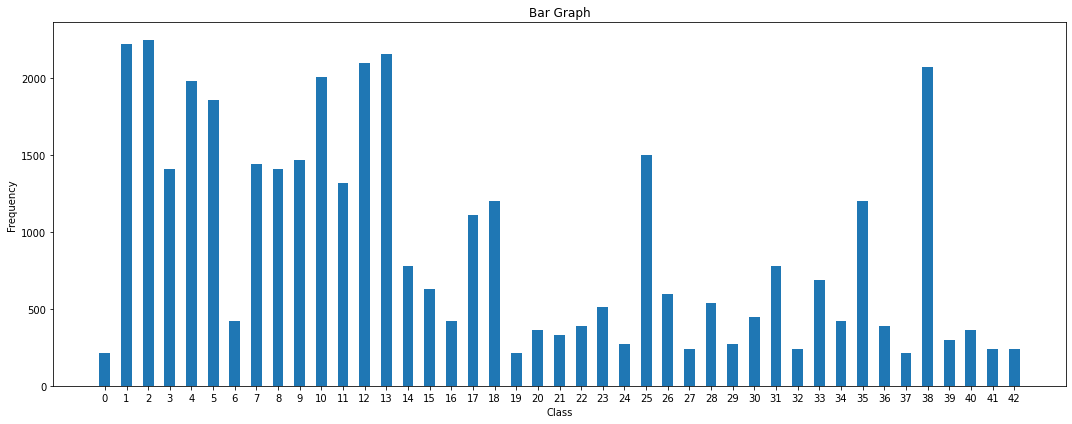

In [7]:
#Statistics of Data
viewStatistics(df)

In [8]:
# df = remove_outlier(df,"length")
# df = remove_outlier(df,"height")

Total Training Examples :  39209


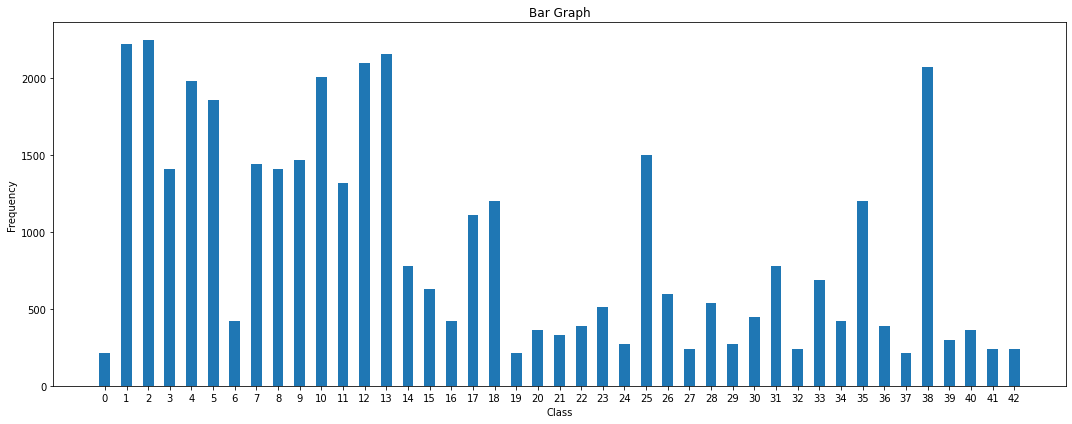

In [9]:
#Statistics of Data
viewStatistics(df)

In [10]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


Total number of images after Upsampling:  86000


Time taken to upsample images :  0.09669782718022664  min
Total Training Examples :  86000


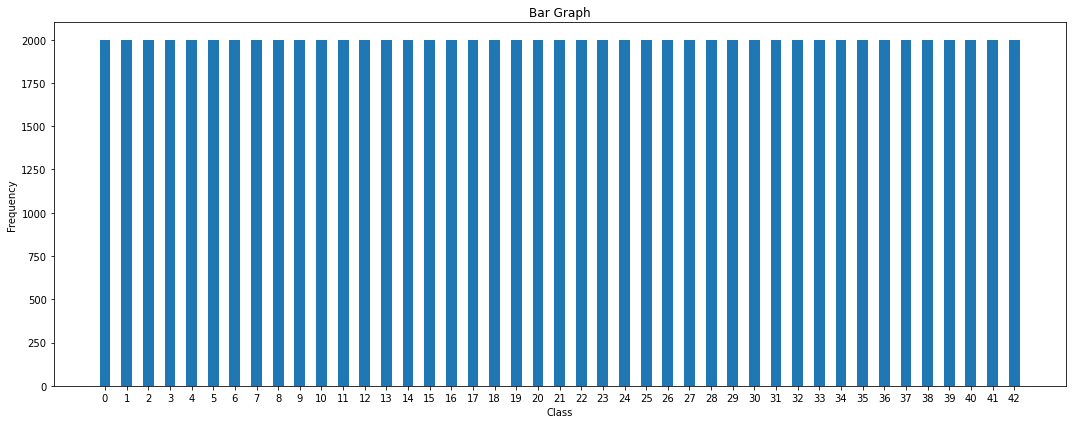

In [11]:
df = upSampleDataFrame(df,2000)
viewStatistics(df)

In [12]:
# Sample Images and there crop according to data given in csv
def resize_and_center(image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[7])
        ax.imshow(img)
        img = img.crop((val[2],val[3],val[4],val[5]))
        img = img.rotate(val[8])
        img = resize_and_center(img,resize_x,resize_y)
        ax = axes[row,col+1]
        ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [13]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

    def Do_Crop(self,path,x1,y1,x2,y2,r):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.rotate(r)
        img = self.resize_and_center(img,self.resize_x,self.resize_y)
        img = np.array(img,dtype=float)
        return img
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row.iloc[7],row.iloc[2],row.iloc[3],row.iloc[4],row.iloc[5],row.iloc[8]))
        self.Y.append(int(row.iloc[6]))
    
    def Get_Data(self,length):
        self.X = []
        self.Y = []
        want = [0]*num_of_classes
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            if(want[int(row.iloc[6])]<length):
                want[int(row.iloc[6])] = want[int(row.iloc[6])]+1
                self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)

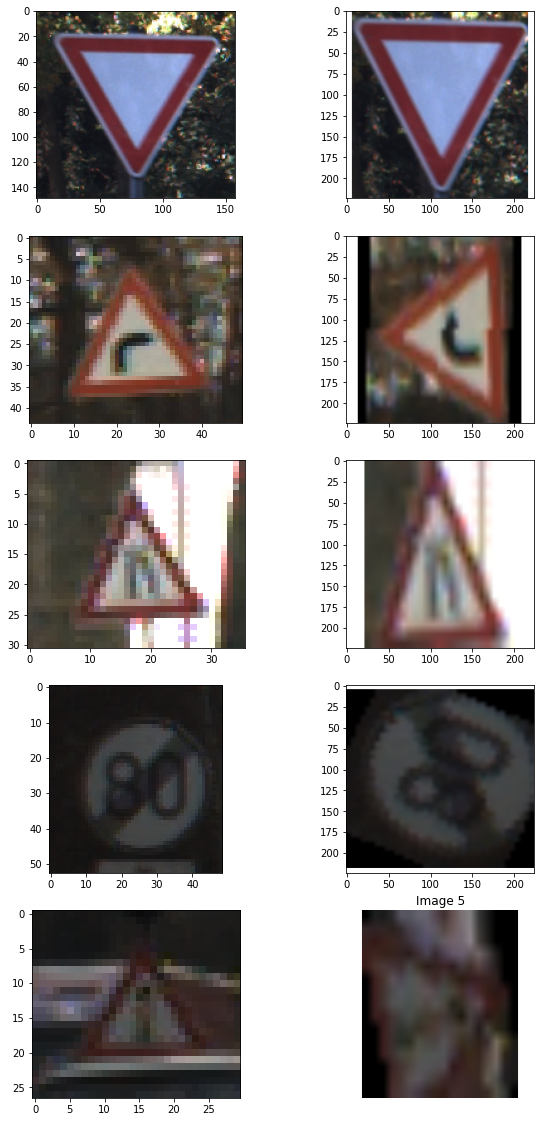

In [14]:
showExamples(df)

In [15]:
def miniDataTrain(model,df):
    data = Data(df,resize_x,resize_y)
    data.Get_Data()
    X_train = data.X
    Y_train = data.Y
    X_train = X_train/255.0
    history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.1)
    return history    

def fullDataTrain(model,df,batchsize=2000):
    num_train = len(df)
    num_mini_trains = math.ceil(num_train/batchsize)
    print("Total Mini Trainings : ", num_mini_trains)
    for i in range(num_mini_trains):
        if(num_mini_trains == i+1):
            df1 = df.iloc[i*batchsize:,:]
            miniDataTrain(model,df1)
        else :
            df1 = df.iloc[i*batchsize:(i+1)*batchsize,:]
            miniDataTrain(model,df1)

In [16]:
# Load pre-trained ResNet50 model with random weights
model = MobileNetV3Large(weights=None, input_shape=(224, 224, 3), classes=num_of_classes)

# Display the model summary
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# starting_time = time.time()

# fullDataTrain(model,df,860)
# ending_time = time.time()
# total_time = ending_time - starting_time
# total_time/=60

# print("Time taken fit : ",total_time," min")

In [20]:
#Saving the model
# model.save("VGG16_MODEL")

In [21]:
# training_accuracy = history.history['accuracy']
# validation_accuracy = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

In [22]:
# epochs  = [x for x in range(Epochs)]
# plt.figure(figsize=(10,5))
# plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
# plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

In [23]:
# epochs  = [x for x in range(Epochs)]
# plt.figure(figsize=(10,5))
# plt.plot(epochs,loss,color="blue",label="training loss")
# plt.plot(epochs,val_loss,color="red",label="validation loss")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [24]:
#Loading weights into CNN model 
model = tf.keras.models.load_model("VGG16_MODEL")

In [25]:
df_test = pd.read_csv(testdir)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test['Rotate']=0
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate
0,53,54,6,5,48,49,16,Test/00000.png,0
1,42,45,5,5,36,40,1,Test/00001.png,0
2,48,52,6,6,43,47,38,Test/00002.png,0
3,27,29,5,5,22,24,33,Test/00003.png,0
4,60,57,5,5,55,52,11,Test/00004.png,0


Total Training Examples :  12630


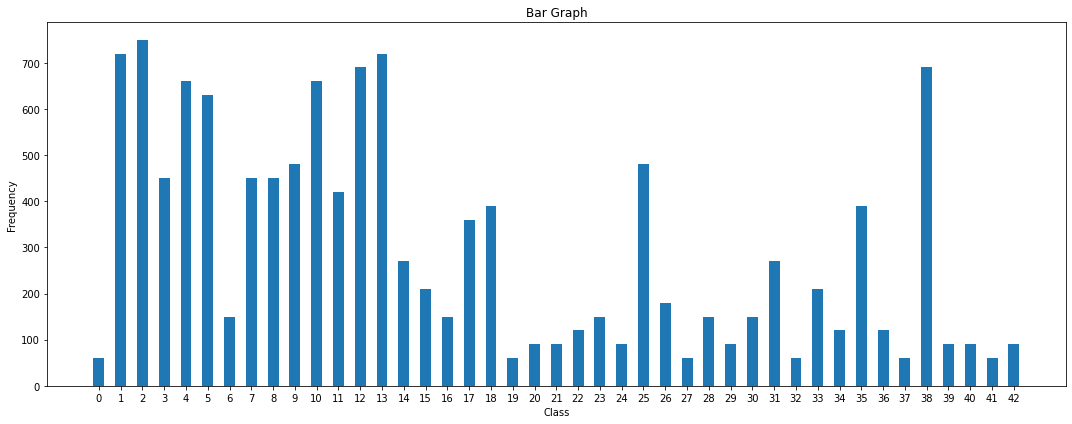

In [26]:
viewStatistics(df_test)

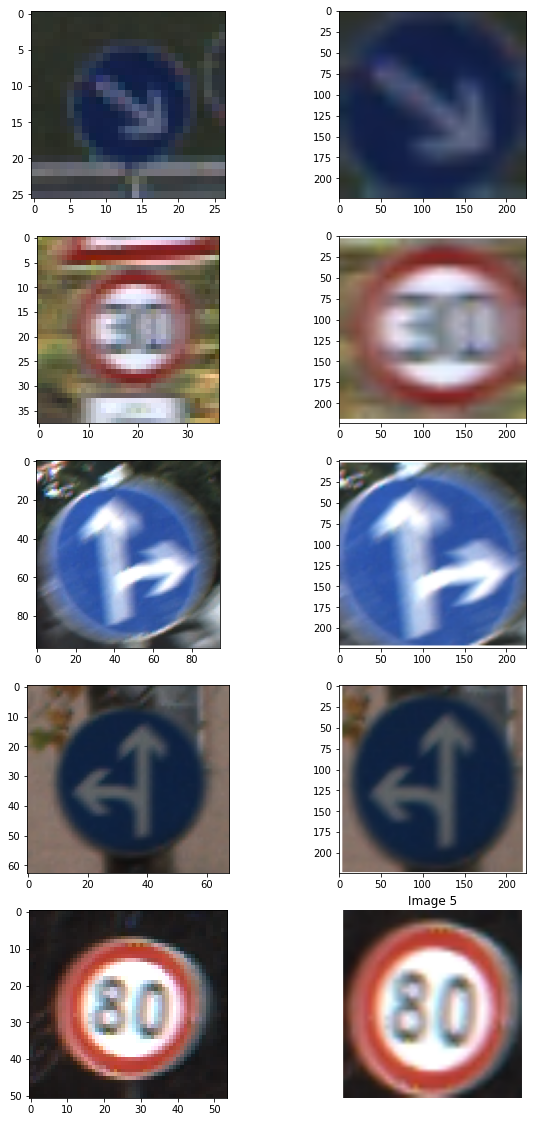

In [27]:
showExamples(df_test)

In [28]:
df_test = upSampleDataFrame(df_test,750)

Total number of images after Upsampling:  32250


Time taken to upsample images :  0.03310490051905314  min


In [29]:
df_test.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate
count,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000,32250.000000
mean,52.642543,52.101271,6.126481,6.095969,46.864279,46.383938,21.000000,109.723008
std,28.649313,26.438594,1.850393,1.655273,27.024308,24.983469,12.409866,119.524329
min,25.000000,25.000000,1.000000,5.000000,20.000000,20.000000,0.000000,0.000000
25%,34.000000,35.000000,5.000000,5.000000,29.000000,30.000000,10.000000,0.000000
50%,44.000000,44.000000,6.000000,6.000000,38.000000,39.000000,21.000000,65.000000
75%,60.000000,59.000000,6.000000,6.000000,55.000000,54.000000,32.000000,213.000000
max,266.000000,232.000000,23.000000,19.000000,244.000000,212.000000,42.000000,359.000000


In [30]:
# Test Images Prediction
y_test,y_pred = PredictTest(model,df_test)

In [31]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  2.4186046511627906

Confusion Matrix:
 [[0 0 6 ... 3 0 0]
 [0 0 7 ... 0 0 0]
 [0 0 4 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,2,0.24,0.01,0.01,750
1,4,0.00,0.00,0.00,750
2,5,0.00,0.00,0.00,750
3,14,0.01,0.00,0.01,750
4,17,0.02,1.00,0.05,750
5,21,0.50,0.00,0.00,750
6,26,0.00,0.00,0.00,750
7,27,0.59,0.01,0.03,750
8,29,0.27,0.00,0.01,750
9,32,0.00,0.00,0.00,750


In [32]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Rotate
0,40,44,6,6,35,39,20,Test/02995.png,259
1,49,45,6,5,44,40,23,Test/02559.png,189
2,57,59,5,6,52,54,7,Test/01621.png,0
3,26,27,5,6,21,22,8,Test/08923.png,161
4,48,45,5,6,43,40,13,Test/02134.png,0


Original Value :  40
Predicted Value :  17


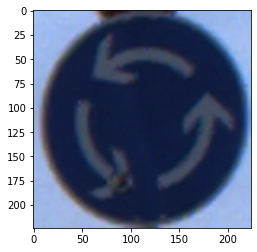

In [33]:
# Testing one Random Image from test data 
test_length = len(df_test)
select_row  = np.random.randint(0, test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row.iloc[7])
img = img.crop((row.iloc[2],row.iloc[3],row.iloc[4],row.iloc[5]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)

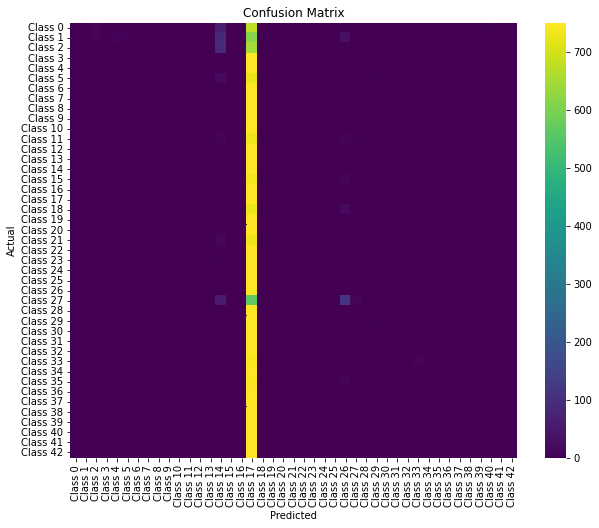

In [34]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()